# Urban Cycling Dynamics: A Comprehensive Analysis of Bike Counts in Germany — Part 2

## Trying out Models for Predictions

### Preparing the code

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
from datetime import datetime

## Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from matplotlib.pylab import rcParams

## Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [134]:
# Set the random seed
RANDOM_SEED = np.random.seed(0)
rcParams['figure.figsize'] = 10, 6

# Load the data
muc_2015 = "./munich2015.csv"
muc_2016 = "./munich2016.csv"
muc_2017 = "./munich2017.csv"
muc_2018 = "./munich2018.csv"
muc_2019 = "./munich2019.csv"
muc_2020 = "./munich2020.csv"
muc_2021 = "./munich2021.csv"
muc_2022 = "./munich2022.csv"

# Read the data
df_muc_2015 = pd.read_csv(muc_2015)
df_muc_2016 = pd.read_csv(muc_2016)
df_muc_2017 = pd.read_csv(muc_2017)
df_muc_2018 = pd.read_csv(muc_2018)
df_muc_2019 = pd.read_csv(muc_2019)
df_muc_2020 = pd.read_csv(muc_2020)
df_muc_2021 = pd.read_csv(muc_2021)
df_muc_2022 = pd.read_csv(muc_2022)

# Concatenate the data
df_munich = pd.concat([df_muc_2015,df_muc_2016,df_muc_2017,df_muc_2018,df_muc_2019,df_muc_2020,df_muc_2021,df_muc_2022], ignore_index=True)

In [135]:
# List of columns to drop, as they are not needed for the analysis and visualization of the data
columns_to_drop = ['uhrzeit_start', 'uhrzeit_ende', 'kommentar', 'richtung_1', 'richtung_2', 'bewoelkung', 'sonnenstunden']

# Rename the columns to make them more readable and easier to work with
df_munich = df_munich.rename(columns={
    'datum':'Date',
    'zaehlstelle': 'Location',
    'gesamt':'Total',
    'min.temp':'MinTemp',
    'max.temp':'MaxTemp',
    'niederschlag':'RainfallVolume'})

# Drop the columns that are not needed
df_munich = df_munich.drop(columns=columns_to_drop)

# Sort the data by date in ascending order to make it easier to work with the time series data later
df_munich = df_munich.sort_values(by='Date')

# Convert the date column to datetime format
df_munich['Date'] = pd.to_datetime(df_munich['Date'])

# Calculate average temperature from min and max temperature columns and add it to the dataframe as a new column called 'AvgTemp'
df_munich['AvgTemp'] = (df_munich['MinTemp'] + df_munich['MaxTemp']) / 2

# Get list of unique locations names and print them out to the console to see what locations are in the data set
unique_locations = df_munich['Location'].unique()
print(unique_locations)
df_munich.info()

['Arnulf' 'Olympia' 'Hirsch' 'Kreuther' 'Margareten' 'Erhardt']
<class 'pandas.core.frame.DataFrame'>
Index: 17501 entries, 0 to 17500
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            17501 non-null  datetime64[ns]
 1   Location        17501 non-null  object        
 2   Total           17051 non-null  float64       
 3   MinTemp         17501 non-null  float64       
 4   MaxTemp         17501 non-null  float64       
 5   RainfallVolume  17501 non-null  float64       
 6   AvgTemp         17501 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.1+ MB


In [136]:
# Create a new dataframe for the selected location (Erhardt) and reset the index
df_location_erhardt = df_munich[df_munich['Location']=='Erhardt'].reset_index()
# Drop the index column as it is not needed and rename the columns to make them more readable
df_location_erhardt = df_location_erhardt.drop(columns=['Location','index'])
# Round the average temperature to one decimal place
df_location_erhardt['AvgTemp'] = df_location_erhardt['AvgTemp'].round(1)
# Convert the date column to datetime format
df_location_erhardt['Date'] = pd.to_datetime(df_location_erhardt['Date'])
# Add a calculated column for the Day of the Week
df_location_erhardt['DayOfWeek'] = df_location_erhardt['Date'].dt.dayofweek + 1  # Adding 1 to have Monday as 1
# Add a calculated column for the Month
df_location_erhardt['Month'] = df_location_erhardt['Date'].dt.month
# Add a calculated column for the Year
df_location_erhardt['Year'] = df_location_erhardt['Date'].dt.year
df_m_e_model = df_location_erhardt[['Date','Total']]
# Set the date column as the index
df_m_e_model = df_m_e_model.set_index(['Date'])
# Set the date column as the index
df_location_erhardt = df_location_erhardt.set_index(['Date'])
# Set the frequency of the index to daily (D) as the data is daily
df_m_e_model.index.freq = 'D'

In [150]:
df_location_erhardt.to_csv('munich_erhardt.csv', index=False)

In [138]:
# Perform Augmented Dickey–Fuller test to check for stationarity of the time series data and print the results
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_m_e_model['Total'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

# Perform KPSS test
result = kpss(df_m_e_model)

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Results of Dickey Fuller Test:


Test Statistic                   -3.669835
p-value                           0.004558
#Lags Used                       28.000000
Number of Observations Used    2893.000000
Critical Value (1%)              -3.432612
Critical Value (5%)              -2.862540
Critical Value (10%)             -2.567302
dtype: float64
Test Statistic: 1.113281649902229
P-value: 0.01


/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/ipykernel_1004/595733836.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df_m_e_model)


## Notes:
The Augmented Dickey-Fuller (ADF) test result suggests that the time series is  **stationary**, as indicated by a p-value less than 0.05, which means that we likely don't need to difference the data to make it stationary. However, the KPSS test result suggests the presence of a trend in your series, which is something to keep in mind as we model.

## Next Steps in Modeling
### Seasonality and Trend Decomposition: 
Before diving into modeling, it might be helpful to decompose the time series into trend, seasonal, and residual components using seasonal_decompose. <br> 
This can give insights into the nature of the underlying patterns in the data, such as regular seasonal effects or long-term trends, which can influence the choice of model.<br><br><br>
The seasonal decomposition output you've provided gives you a breakdown of the components within your time series data. Each subplot represents a different component that, when combined, reconstruct your original time series data. Let's go through each one:

### Top Subplot: Original Bike Counts
- This is your raw data. It shows the number of bike counts over time. You can see the overall patterns, trends, and cycles in the data. For instance, there might be periodic peaks and troughs corresponding to specific times of the year, such as warmer or colder months when people are more or less likely to cycle.

### Second Subplot: Trend
- The trend component represents the long-term progression of your time series data. It's the smooth, slowly varying aspect of the series. The trend shows changes in the data that aren't tied to seasonality or irregular fluctuations. In your plot, the trend captures the upward or downward movements over several years. This might be due to increasing or decreasing popularity of biking, changes in population, or other long-term factors affecting bike usage.

### Third Subplot: Seasonality
- The seasonality component captures the regular pattern that occurs at fixed periods, such as daily, weekly, monthly, or yearly. This is the cyclical effect that is seen consistently over time. In your plot, this would represent the cycling patterns that repeat in a consistent way over the given period. It looks like a constant series because the seasonal effect is consistent and is being repeated for each cycle. This could represent more people biking in warmer months and fewer in colder months, assuming the data has a yearly cycle.

### Bottom Subplot: Residuals
- The residuals, or sometimes called "irregular" or "remainder", represent the random variation in the data after the trend and seasonality have been removed. These are fluctuations that cannot be attributed to the trend or seasonal components. They might be due to random, unpredictable events or might be noise. Ideally, you want your residuals to look like "white noise"—a series of random fluctuations that don't show any pattern.

### Interpretation Tips for Thesis Writing:
1. **Contextualize Your Components**: When writing your thesis, make sure you explain these components in the context of the real-world phenomena they might represent. For example, if bike counts increase over the years, consider what might cause this trend—is there a city policy promoting biking, or has there been an increase in bike lanes?

2. **Seasonality**: For the seasonality component, try to match the observed pattern with known seasonal events, such as weather changes, holidays, or city events that could affect bike usage. It's essential to explain why the seasonality might

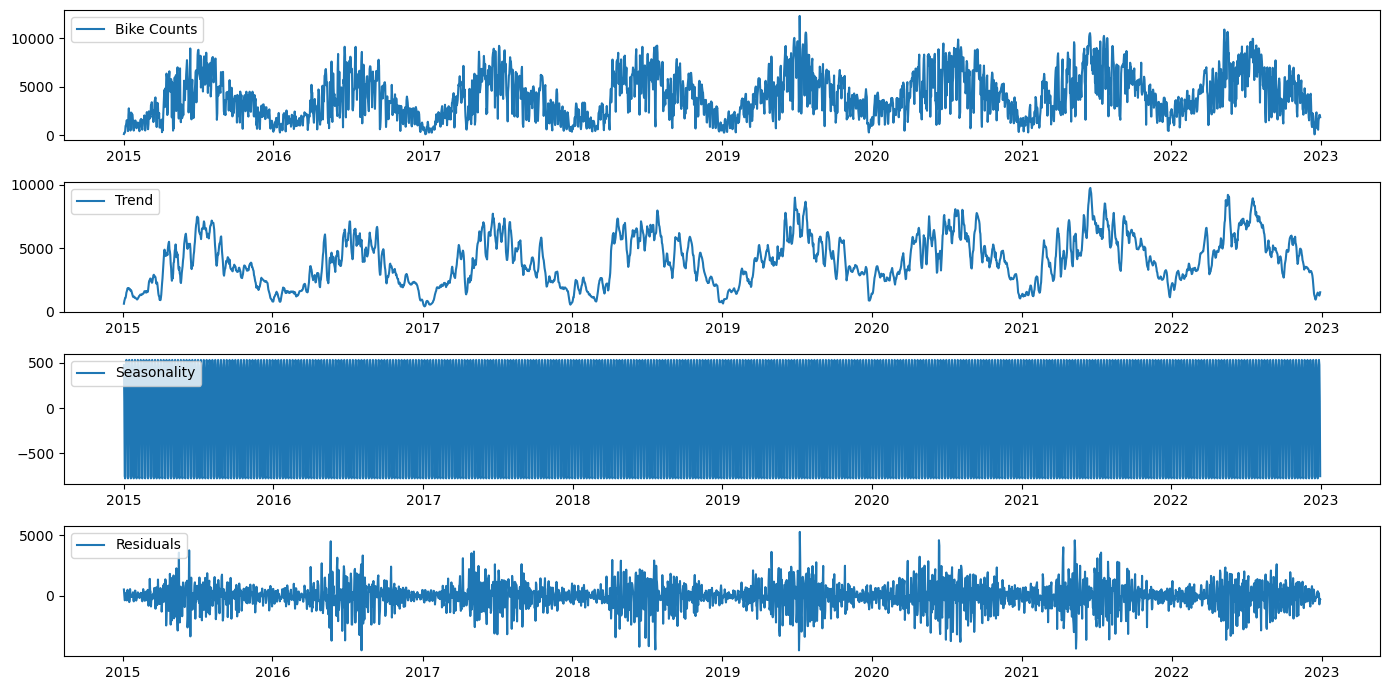

In [139]:
decomposition = seasonal_decompose(df_m_e_model['Total'], model='additive') # Use an additive model when the seasonal variations are roughly constant through the series

# Assign the trend, seasonal, and residual components to separate variables
trend = decomposition.trend # The trend component
seasonal = decomposition.seasonal # The seasonal component
residual = decomposition.resid # The residual component

# Plot the decomposed components
plt.figure(figsize=(14,7))

# Plot the original data (Bike Counts)
plt.subplot(411)
plt.plot(df_m_e_model['Total'], label='Bike Counts')
plt.legend(loc='upper left')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()

These ACF and PACF plots are useful for determining the parameters of an ARIMA(p,d,q) model.

### Autocorrelation Function (ACF) plot
It shows the correlation of the series with its own lags. In this plot, we see a gradual decline in the autocorrelations as the number of lags increases, which suggests that there is a significant amount of autocorrelation present. The autocorrelations are still within the confidence interval for many lags, but slowly decreasing.

### Partial Autocorrelation Function (PACF) plot 
This shows the partial correlation of a series with its own lagged values, controlling for the values of the time series at all shorter lags. The PACF cuts off after the first lag in our plot, which suggests an AR(1) component might be appropriate. This is because after the first lag, the partial autocorrelations are essentially zero, indicating no additional correlation beyond the first lag. <br><br>
When using the PACF to help build an AR model, we’re looking for where the PACF plot cuts off because that suggests the number of past values which significantly affect the current value. If the PACF plot shows a sharp drop after lag 1 and the rest of the lags are not significant, this implies an AR(1) model could be appropriate. It means that only the first lag has a significant partial correlation with the current value after accounting for the correlations at all shorter lags.

#### The Role of PACF in Model Selection
Why is this useful? In ARIMA modeling, we need to know how many AR terms to include. The PACF plot can help us determine this. If we see a sharp cut-off in the PACF at lag 1, and the rest of the lags are within the blue shaded area (which represents a confidence interval for the statistical significance), then we would consider starting with an AR(1) model. If the cut-off were at lag 2, we might start with an AR(2), and so on.

### What the Plots Suggest for Model Parameters:

For an **ARIMA model**, the p parameter can be initially chosen based on where the PACF cuts off (after lag 1 in our case). This would suggest a potential ARIMA(p,d,q) model with p=1. <br><br>
The d parameter is the degree of differencing required to make the series stationary. Since our ADF test suggested the series was stationary, we may not need any differencing (d=0), but we should verify this by looking at the data and considering the KPSS test result, which suggested a trend.<br><br>
The q parameter can be chosen based on where the ACF plot tails off. However, in our plot, the ACF does not sharply cut off, which makes it more difficult to choose the q value. It slowly decreases, which might indicate a Moving Average (MA) component is less clear, and we might start with q=0 or q=1 and experiment from there.

KeyboardInterrupt: 

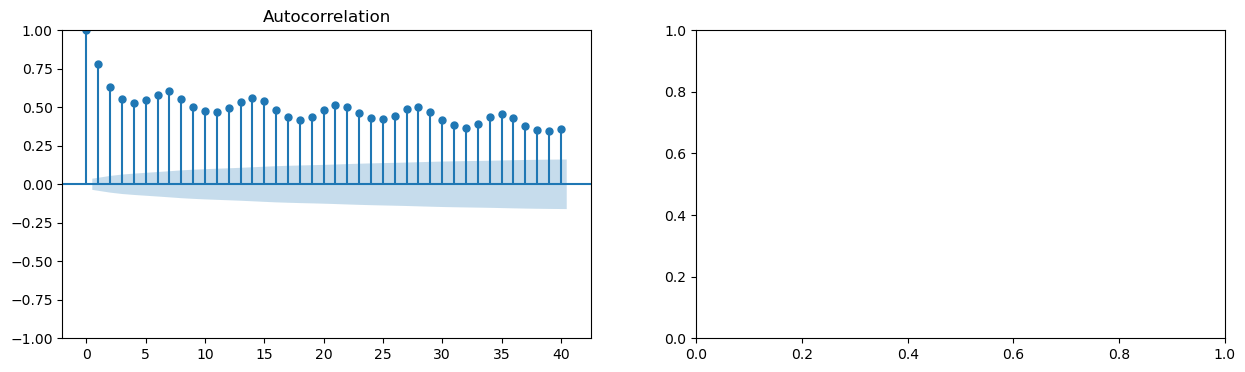

In [140]:
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot the Autocorrelation Function (ACF)
plot_acf(df_m_e_model['Total'], lags=40, ax=axes[0])

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(df_m_e_model['Total'], lags=40, ax=axes[1])

plt.tight_layout()
plt.show()

## ARIMA model 

**The ARIMA model** has three parameters (p, d, q):

p is the number of autoregressive terms (AR).
d is the number of nonseasonal differences needed for stationarity.
q is the number of lagged forecast errors in the prediction equation (MA or moving average terms).
The PACF helps with determining the 'p' part of the ARIMA model. If the PACF indicates an AR(1) model, then p would be set to 1 when specifying your ARIMA model.

In [ ]:
# Make sure your data does not contain any NaN values, as the ARIMA model cannot handle them. 
df_m_e_model = df_m_e_model.dropna()

# Start with the parameters (p=1, d=0, q=0) based on the PACF plot.
arima_model = ARIMA(df_m_e_model['Total'], order=(2, 0, 2))

# Fit the model
arima_result = arima_model.fit()

# Print out the summary of the fit
print(arima_result.summary())


/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 2922
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -25209.256
Date:                Sat, 16 Mar 2024   AIC                          50430.512
Time:                        02:44:04   BIC                          50466.392
Sample:                    01-01-2015   HQIC                         50443.435
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4045.8411    542.186      7.462      0.000    2983.176    5108.506
ar.L1          1.3538      0.036     37.496      0.000       1.283       1.425
ar.L2         -0.3595      0.035    -10.217      0.0

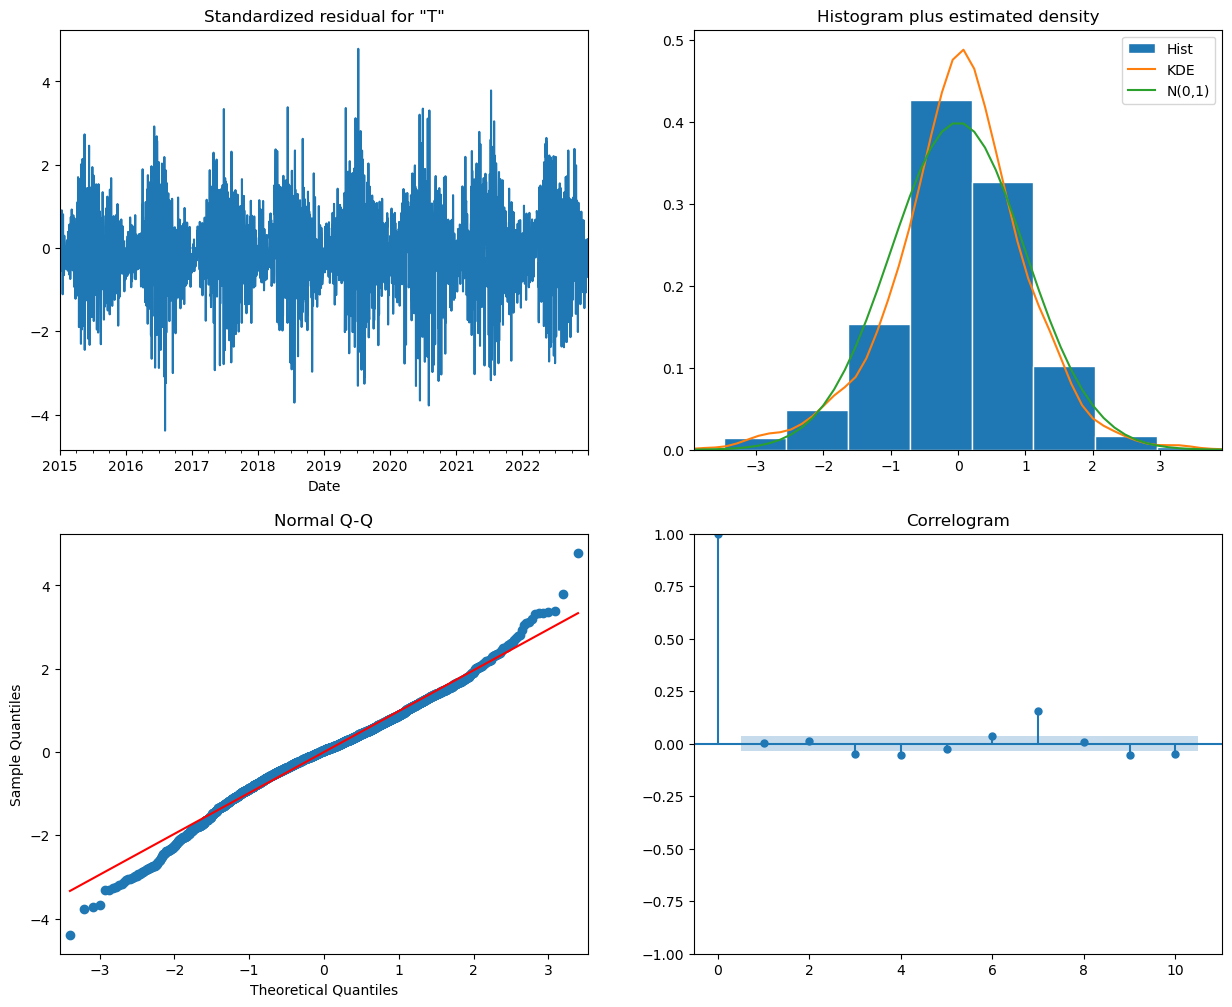

In [ ]:
arima_result.plot_diagnostics(figsize=(15, 12))
plt.show()

## SARIMA
To extend the ARIMA model to a Seasonal ARIMA (SARIMA) model, you will incorporate seasonal elements into the model. SARIMA is denoted as SARIMA(p,d,q)(P,D,Q)s, where:

- p,d,q are the non-seasonal parameters that describe the autoregressive, differencing, and moving average parts of the ARIMA model.
- P,D,Q are the seasonal parts of the same that describe the seasonal autoregressive, differencing, and moving average parts of the SARIMA model.
- s is the periodicity of the time series (e.g., if the seasonality is yearly and data is collected monthly, s=12).

<br> First, identify if there is a seasonality component by looking at your data or the seasonal decomposition you performed earlier. Once you know the seasonality, you can start to build your SARIMA model.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76863D+00    |proj g|=  7.11809D-02


 This problem is unconstrained.



At iterate    5    f=  8.74723D+00    |proj g|=  2.50352D-02

At iterate   10    f=  8.69650D+00    |proj g|=  4.89331D-02

At iterate   15    f=  8.69286D+00    |proj g|=  2.69149D-03

At iterate   20    f=  8.69272D+00    |proj g|=  9.13645D-04

At iterate   25    f=  8.69270D+00    |proj g|=  1.05356D-03

At iterate   30    f=  8.69155D+00    |proj g|=  7.74346D-03

At iterate   35    f=  8.68012D+00    |proj g|=  9.28738D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     60      1     0     0   5.016D-02   8.616D+00
  F =   8.6161080202741012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                 2922
Model:             SARIMAX(2, 0, 4)x(1, 1, [1], 12)   Log Likelihood              -25176.268
Date:                              Sat, 16 Mar 2024   AIC                          50370.535
Time:                                      04:17:57   BIC                          50424.318
Sample:                                  01-01-2015   HQIC                         50389.911
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        4.49e-05      0.019      0.002      0.998      -0.037       0.038
ar.L2          1.00

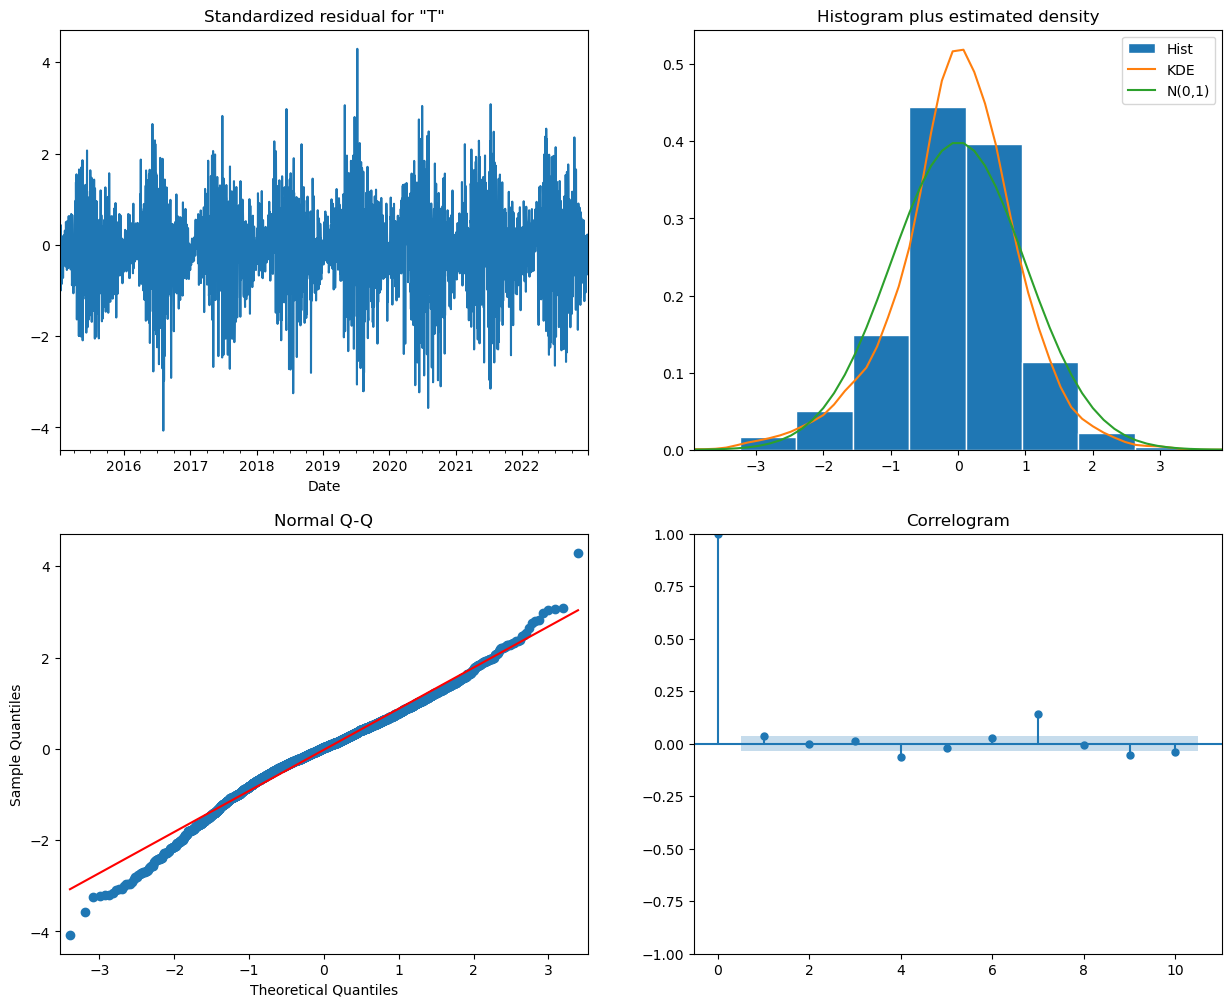

In [ ]:
# Define the SARIMA model with some starting orders
sarima_model = SARIMAX(df_m_e_model['Total'], 
                       order=(2, 0, 4),              # non-seasonal (p, d, q) parameters 1,0,0 ->50585.294
                       seasonal_order=(1, 1, 1, 12)) # the seasonal (P, D, Q, s) parameters

# Fit the model
sarima_result = sarima_model.fit()

# Summarize the model results
print(sarima_result.summary())

# Run model diagnostics
sarima_result.plot_diagnostics(figsize=(15, 12))
plt.show()


- The output from your SARIMAX model fit indicates several key points and some warnings to consider:

- **Convergence Warning**
The warning message you received suggests that the optimization algorithm used to find the best parameters for your model didn't converge, which means it didn't find a solution that's a good fit for your data within the given number of iterations or there might be some issues with the data or the model specification. This doesn't mean the model is useless, but it does suggest that results might not be as reliable.

- **SARIMAX Results**
The SARIMAX(2, 1, 2)x(1, 1, [1], 12) model you've fit includes:

    - **Non-seasonal AR(2), differencing(1), MA(2) components**
Seasonal AR(1), differencing(1), MA(1) components with a period of 12.
The coefficients for the ar.L1, ar.L2, ma.L1, ma.L2, and ma.S.L12 are significant (p-values are small), while the coefficient for ar.S.L12 is not significant (p-value is large). The non-significant term may not be contributing to the model and could be removed.

- **Model Fit Statistics**
Log Likelihood: The log likelihood is higher (less negative), which generally indicates a better model fit compared to simpler models.
AIC, BIC, HQIC: The Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), and Hannan-Quinn Information Criterion (HQIC) are lower than in your initial ARIMA(1,0,0) model, suggesting an improved fit.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83667D+00    |proj g|=  3.47514D-01

At iterate    5    f=  8.67725D+00    |proj g|=  6.97700D-02

At iterate   10    f=  8.65972D+00    |proj g|=  4.46746D-02

At iterate   15    f=  8.65931D+00    |proj g|=  9.52516D-04

At iterate   20    f=  8.65858D+00    |proj g|=  2.45523D-02

At iterate   25    f=  8.65655D+00    |proj g|=  2.16725D-02

At iterate   30    f=  8.65647D+00    |proj g|=  2.60577D-04

At iterate   35    f=  8.65647D+00    |proj g|=  2.90704D-03

At iterate   40    f=  8.65623D+00    |proj g|=  2.45244D-02

At iterate   45    f=  8.64982D+00    |proj g|=  2.85625D-01

At iterate   50    f=  8.64786D+00    |proj g|=  1.00076D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                 2922
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood              -25269.034
Date:                              Fri, 15 Mar 2024   AIC                          50552.068
Time:                                      21:44:52   BIC                          50593.861
Sample:                                  01-01-2015   HQIC                         50567.128
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5182      0.044     34.535      0.000       1.432       1.604
ar.L2         -0.54

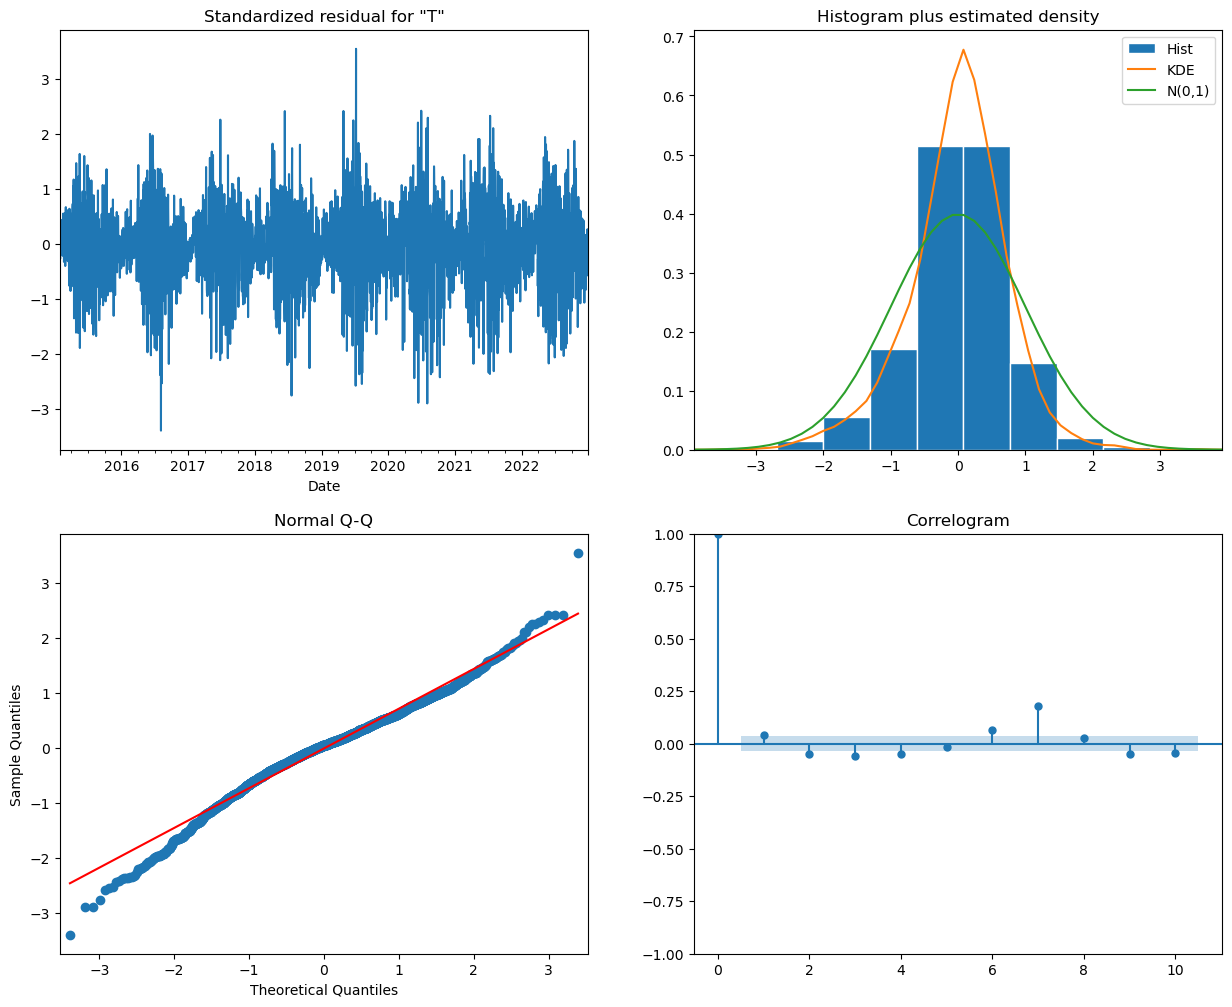

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model with some starting orders and fit the model to the data
model = SARIMAX(df_m_e_model['Total'],
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Print the summary of the model
print(results.summary())
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
from scipy.stats import pearsonr, spearmanr

# Calculate the Pearson correlation coefficient and the p-value for testing non-correlation
p_temp_corr, p_temp_p_val = pearsonr(df_location_erhardt['Total'], df_location_erhardt['AvgTemp'])

# Calculate the Pearson correlation coefficient and the p-value for testing rainfall correlation
p_rain_corr, p_rain_p_val = pearsonr(df_location_erhardt['Total'], df_location_erhardt['RainfallVolume'])

# Calculate the Spearman rank-order correlation coefficient and the p-value for testing non-correlation
s_temp_corr, s_temp_p_val = spearmanr(df_location_erhardt['Total'], df_location_erhardt['AvgTemp'])

# Calculate the Spearman correlation coefficient and the p-value for testing rainfall correlation
s_rain_corr, s_rain_p_val = spearmanr(df_location_erhardt['Total'], df_location_erhardt['RainfallVolume'])

# Print the results
print(f"Pearson Correlation Coefficient (Temperature): {p_temp_corr}")
print(f"Pearson P-value (Temperature): {p_temp_p_val}")
print(f"Pearson Correlation Coefficient (Rainfall): {p_rain_corr}")
print(f"Pearson P-value (Rainfall): {p_rain_p_val}")
print(f"Spearman Correlation Coefficient (Temperature): {s_temp_corr}")
print(f"Spearman P-value (Temperature): {s_temp_p_val}")
print(f"Spearman Correlation Coefficient (Rainfall): {s_rain_corr}")
print(f"Spearman P-value (Rainfall): {s_rain_p_val}")


Pearson Correlation Coefficient (Temperature): 0.7497344046511719
Pearson P-value (Temperature): 0.0
Pearson Correlation Coefficient (Rainfall): -0.17544475529416395
Pearson P-value (Rainfall): 1.2491167703138117e-21
Spearman Correlation Coefficient (Temperature): 0.7542316978968155
Spearman P-value (Temperature): 0.0
Spearman Correlation Coefficient (Rainfall): -0.3315933157975935
Spearman P-value (Rainfall): 6.158873252178787e-76


The correlation coefficients and p-values calculated provide information on the strength and significance of the linear relationship between bike counts and each of the weather conditions (temperature and rainfall).

### Temperature:
- **Pearson Correlation Coefficient (Temperature)**: At about 0.75, this value indicates a strong positive linear correlation between average temperature and bike counts. As the temperature increases, bike counts also tend to increase.
- **Pearson P-value (Temperature)**: The p-value is 0.0, which is less than the standard threshold of 0.05, indicating that the correlation is statistically significant, and you can be confident that this relationship is not due to random chance.

- **Spearman Correlation Coefficient (Temperature)**: The coefficient is similar to the Pearson's at about 0.75, suggesting a strong monotonic relationship between average temperature and bike counts. This means that as temperature increases, bike counts tend to increase in a consistent manner, even if the relationship is not perfectly linear.
- **Spearman P-value (Temperature)**: Again, a p-value of 0.0 indicates that the correlation is statistically significant.

### Rainfall:
- **Pearson Correlation Coefficient (Rainfall)**: At about -0.18, this indicates a weak inverse linear correlation between rainfall volume and bike counts. This suggests that bike counts tend to decrease slightly on days with more rainfall.
- **Pearson P-value (Rainfall)**: The very small p-value suggests that the correlation is statistically significant, and the inverse relationship is not due to random chance.

- **Spearman Correlation Coefficient (Rainfall)**: At about -0.33, there is a moderate inverse monotonic relationship between rainfall volume and bike counts, stronger than indicated by the Pearson coefficient. This means that generally, as rainfall increases, bike counts tend to decrease, even if the relationship is not linear.
- **Spearman P-value (Rainfall)**: The very small p-value, again, indicates that this correlation is statistically significant.

### Conclusion:
The results show a strong and significant relationship between temperature and bike counts, with higher temperatures being associated with higher bike usage. Rainfall has a negative relationship with bike counts, though the relationship is weaker compared to temperature. Both relationships are statistically significant, meaning that they are unlikely to be due to random variation in the data.

For further analysis, we could:
- Investigate whether other factors affect bike counts, such as day of the week, holidays, or special events.
- Develop regression models or time series models that include temperature and rainfall as explanatory variables to forecast bike counts.
- Explore non-linear models or transformations if the relationship between the weather conditions and bike counts is not strictly linear or if there are issues with heteroscedasticity (non-constant variance).

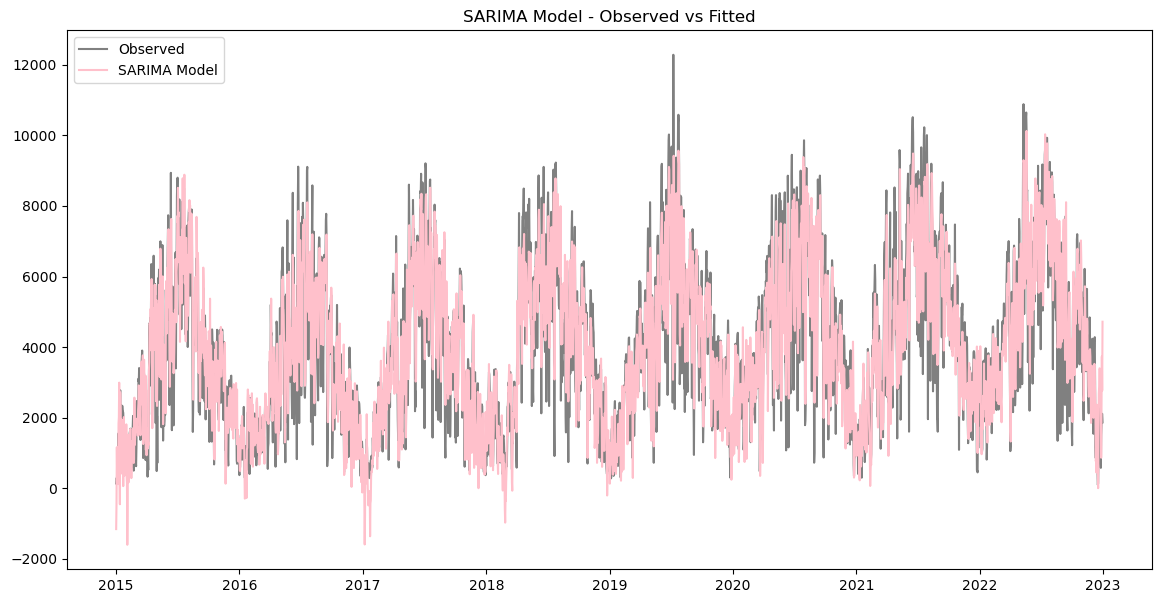

In [ ]:
# Visualize the fitted SARIMA model
plt.figure(figsize=(14,7))
plt.plot(df_m_e_model['Total'], color='grey',label='Observed')
plt.plot(results.fittedvalues, color='pink', label='SARIMA Model')
plt.title('SARIMA Model - Observed vs Fitted')
plt.legend(loc='upper left')
plt.show()

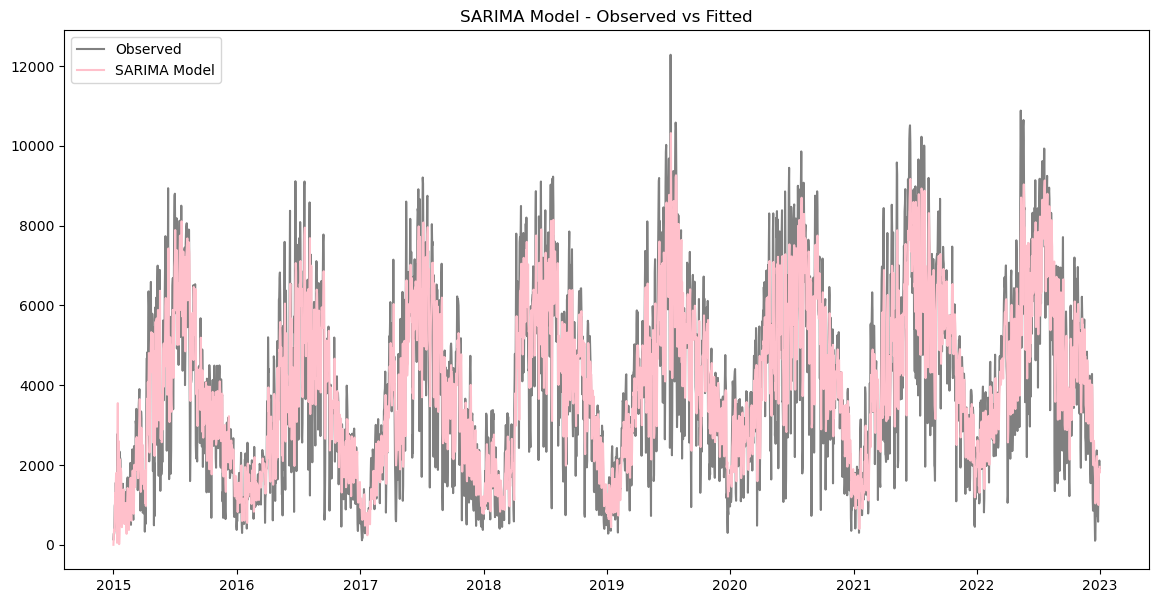

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92337D+00    |proj g|=  7.42129D-03


 This problem is unconstrained.



At iterate    5    f=  8.92333D+00    |proj g|=  2.02386D-04

At iterate   10    f=  8.92331D+00    |proj g|=  4.27490D-03

At iterate   15    f=  8.92040D+00    |proj g|=  5.08904D-02

At iterate   20    f=  8.90483D+00    |proj g|=  6.70947D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   9.356D-07   8.905D+00
  F =   8.9047872484985966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [ ]:
# Divide the data into training and testing sets
# The training set will be used to fit the model, while the testing set will be used to evaluate the model's performance
# The training set will contain data from 2015 to 2021, and the testing set will contain data from 2022
# The testing set will be used to forecast the future values
# The training set will be used to fit the model
df_train = df_m_e_model['Total'][:'2021-12-31']
df_test = df_m_e_model['Total']['2022-01-01':]
model = SARIMAX(df_train, order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
fitted_model = model.fit()
# Get the in-sample prediction
in_sample_prediction = fitted_model.get_prediction(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-12-31'), dynamic=False)
predicted_mean = in_sample_prediction.predicted_mean

# Forecast the future values
forecast = fitted_model.get_forecast(steps=365)
predicted_mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


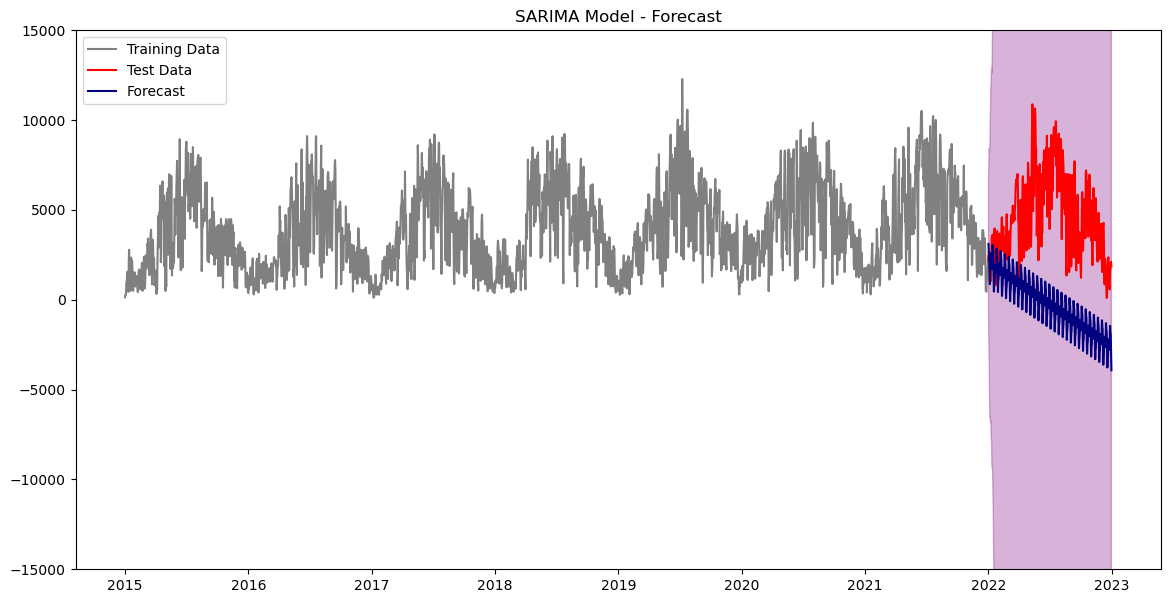

In [ ]:
# Visualize the forecast
plt.figure(figsize=(14,7))
plt.plot(df_train, label='Training Data', color='grey')
plt.plot(df_test, label='Test Data', color='red')
plt.plot(predicted_mean_forecast, label='Forecast', color='navy')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='purple', alpha=0.3)
plt.title('SARIMA Model - Forecast')
plt.ylim(-15000, 15000)
plt.legend(loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate error metrics
mae = mean_absolute_error(df_test, predicted_mean[:len(df_test)])
rmse = mean_squared_error(df_test, predicted_mean[:len(df_test)], squared=False)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 2041.0411789844725
Root Mean Squared Error (RMSE): 2593.365472747916


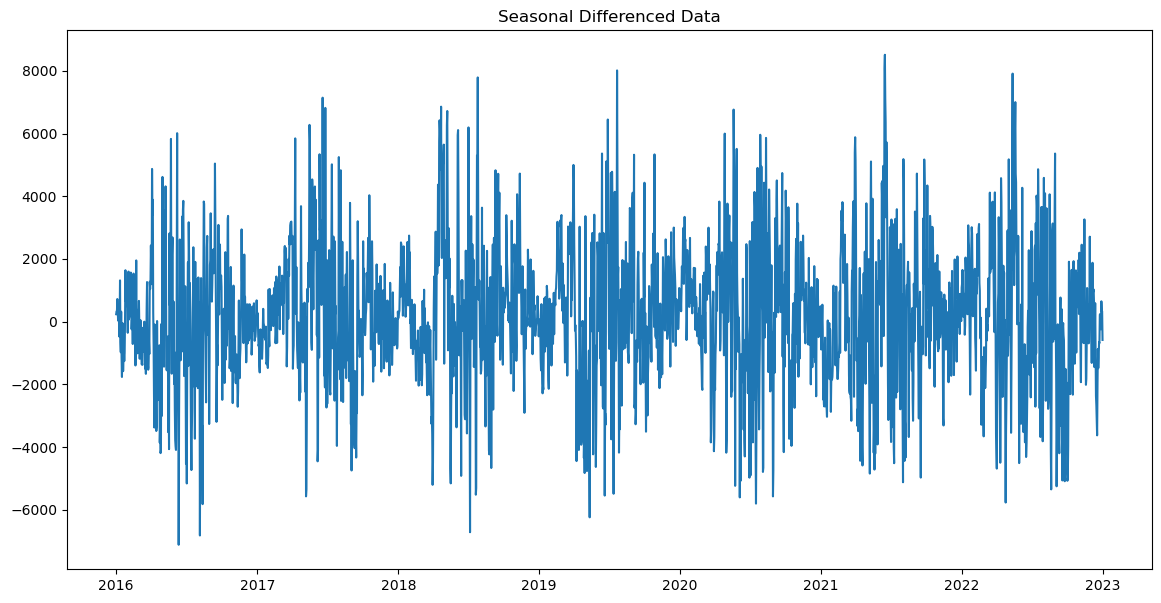

ADF Statistic: -10.693757
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series is stationary.
<class 'pandas.core.series.Series'>
DatetimeIndex: 2557 entries, 2016-01-01 to 2022-12-31
Freq: D
Series name: SeasonalDifference
Non-Null Count  Dtype  
--------------  -----  
2557 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB
None


In [ ]:
## Since the SARIMAX model predictions are not accurate at all we will first try to apply seasonal differencing to the data and then fit the model again
# Apply seasonal differencing to the data
df_m_e_model['SeasonalDifference'] = df_m_e_model['Total'] - df_m_e_model['Total'].shift(365)

df_seasonal_diff = df_m_e_model['SeasonalDifference'].dropna()
# plot the seasonal differenced data
plt.figure(figsize=(14,7))
plt.plot(df_seasonal_diff)
plt.title('Seasonal Differenced Data')
plt.show()

from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test_result = adfuller(df_seasonal_diff)
# Print the test statistic and the p-value
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])
print('Critical Values:')
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation:
if adf_test_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

print(df_seasonal_diff.info())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31182D+00    |proj g|=  7.00079D-01


 This problem is unconstrained.



At iterate    5    f=  8.90659D+00    |proj g|=  2.42661D-01

At iterate   10    f=  8.84931D+00    |proj g|=  2.68478D-01

At iterate   15    f=  8.83877D+00    |proj g|=  6.54317D-02

At iterate   20    f=  8.83631D+00    |proj g|=  2.43792D-02

At iterate   25    f=  8.83615D+00    |proj g|=  9.22011D-02

At iterate   30    f=  8.83579D+00    |proj g|=  1.20013D-02

At iterate   35    f=  8.83570D+00    |proj g|=  1.56123D-02

At iterate   40    f=  8.83566D+00    |proj g|=  7.51274D-03

At iterate   45    f=  8.83559D+00    |proj g|=  4.94232D-03


/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.83557D+00    |proj g|=  1.05107D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     69      1     0     0   1.051D-02   8.836D+00
  F =   8.8355699159346983     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                   SeasonalDifference   No. Observations:                 2557
Model:             SARIMAX(8, 0, 4)x(1, 0, [1], 12)   Log Likelihood              -22592.552
Date:                              Sat, 16 Mar 2024   AIC                         

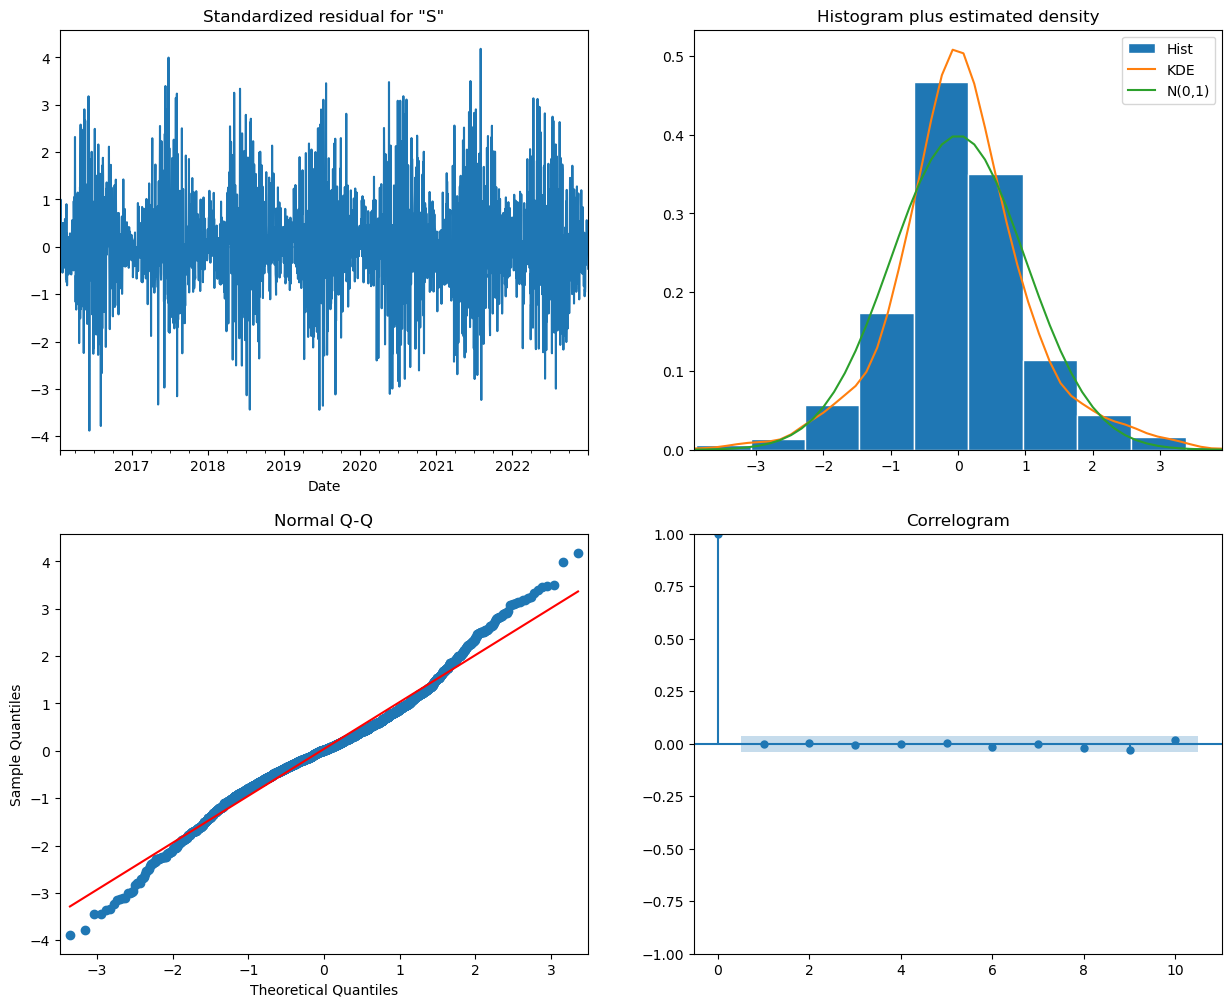

In [ ]:
# Define the SARIMA model with some starting orders and fit the model to the data
model = SARIMAX(df_seasonal_diff,
                order=(8, 0, 4),
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())
# 45339.766
results.plot_diagnostics(figsize=(15, 12))
plt.show()

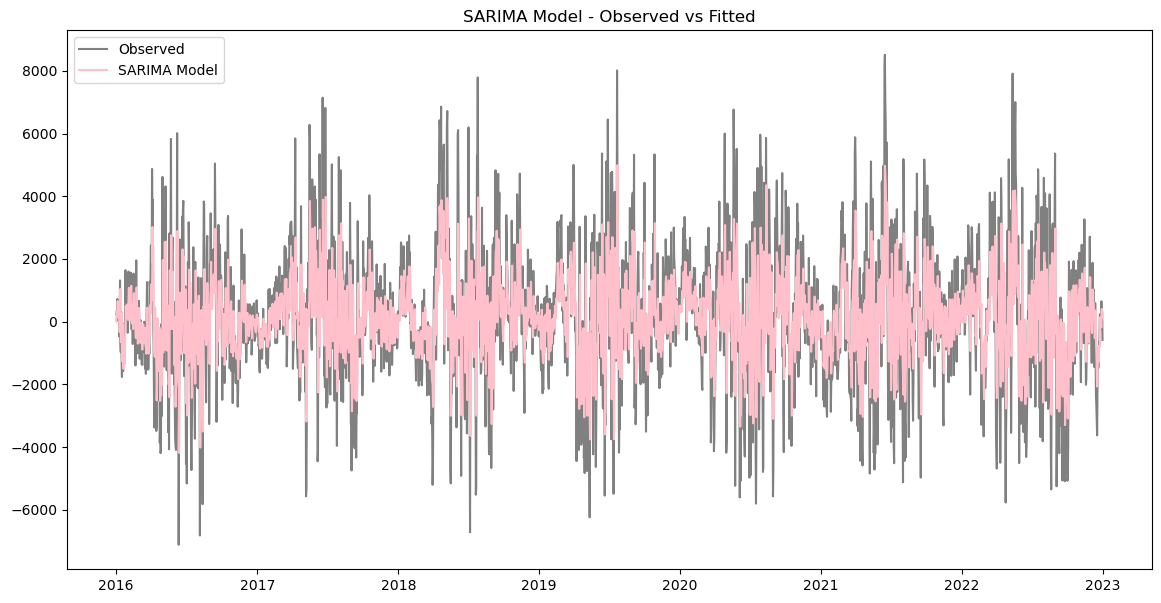

In [ ]:
# Visualize the fitted SARIMA model
plt.figure(figsize=(14,7))
plt.plot(df_seasonal_diff, color='grey',label='Observed')
plt.plot(results.fittedvalues, color='pink', label='SARIMA Model')
plt.title('SARIMA Model - Observed vs Fitted')
plt.legend(loc='upper left')
plt.show()


In [ ]:
# Divide the data into training and testing sets
# The training set will be used to fit the model, while the testing set will be used to evaluate the model's performance
# The training set will contain data from 2015 to 2021, and the testing set will contain data from 2022
# The testing set will be used to forecast the future values
# The training set will be used to fit the model
df_train = df_seasonal_diff[:'2021-12-31']
df_test = df_seasonal_diff['2022-01-01':]
model = SARIMAX(df_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
fitted_model = model.fit()
# Get the in-sample prediction
in_sample_prediction = fitted_model.get_prediction(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-12-31'), dynamic=False)
predicted_mean = in_sample_prediction.predicted_mean

# Forecast the future values
forecast = fitted_model.get_forecast(steps=365)
predicted_mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91103D+00    |proj g|=  2.50396D-02

At iterate    5    f=  8.91070D+00    |proj g|=  3.41756D-04

At iterate   10    f=  8.91067D+00    |proj g|=  2.78753D-03

At iterate   15    f=  8.91043D+00    |proj g|=  5.90804D-03

At iterate   20    f=  8.91035D+00    |proj g|=  1.67800D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   2.858D-06   8.910D+00
  F =   8.9103485235713755     

CONVERG

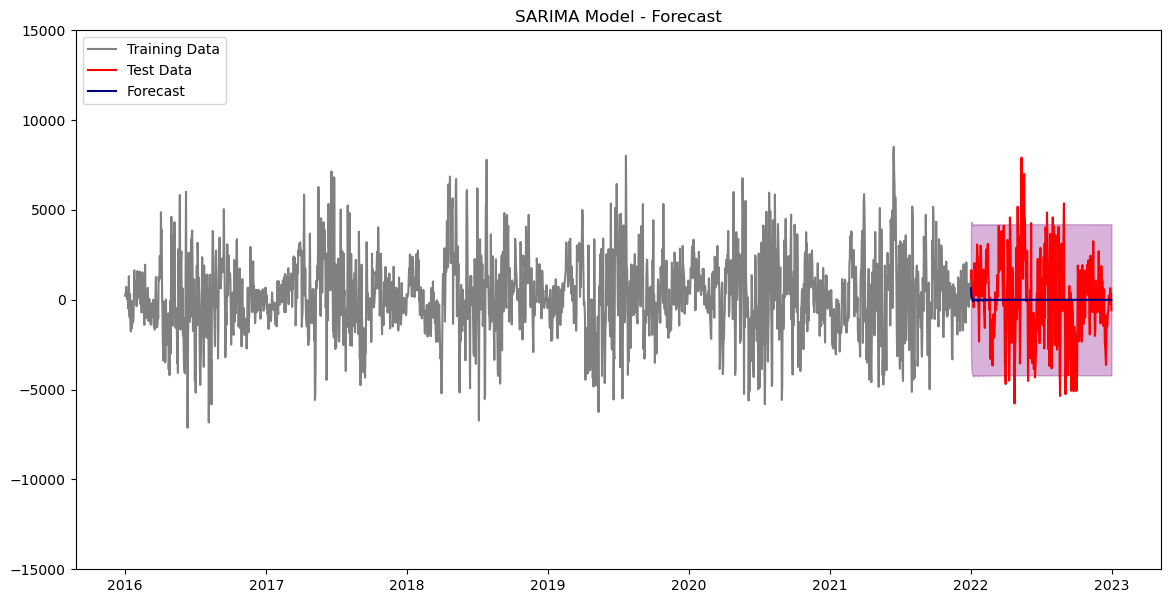

In [ ]:
# Visualize the forecast
plt.figure(figsize=(14,7))
plt.plot(df_train, label='Training Data', color='grey')
plt.plot(df_test, label='Test Data', color='red')
plt.plot(predicted_mean_forecast, label='Forecast', color='navy')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='purple', alpha=0.3)
plt.title('SARIMA Model - Forecast')
plt.ylim(-15000, 15000)
plt.legend(loc='upper left')
plt.show()


## New Model SARIMAX Test
- Including Exogenous Variable

/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62844D+00    |proj g|=  6.73619D-02

At iterate    5    f=  8.59241D+00    |proj g|=  4.61649D-02

At iterate   10    f=  8.58703D+00    |proj g|=  8.34690D-04

At iterate   15    f=  8.58700D+00    |proj g|=  1.19507D-03

At iterate   20    f=  8.58687D+00    |proj g|=  2.39402D-03

At iterate   25    f=  8.58680D+00    |proj g|=  1.79104D-03

At iterate   30    f=  8.58674D+00    |proj g|=  4.85649D-03

At iterate   35    f=  8.58576D+00    |proj g|=  5.99417D-03

At iterate   40    f=  8.56374D+00    |proj g|=  5.10373D-02

At iterate   45    f=  8.50217D+00    |proj g|=  3.67239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

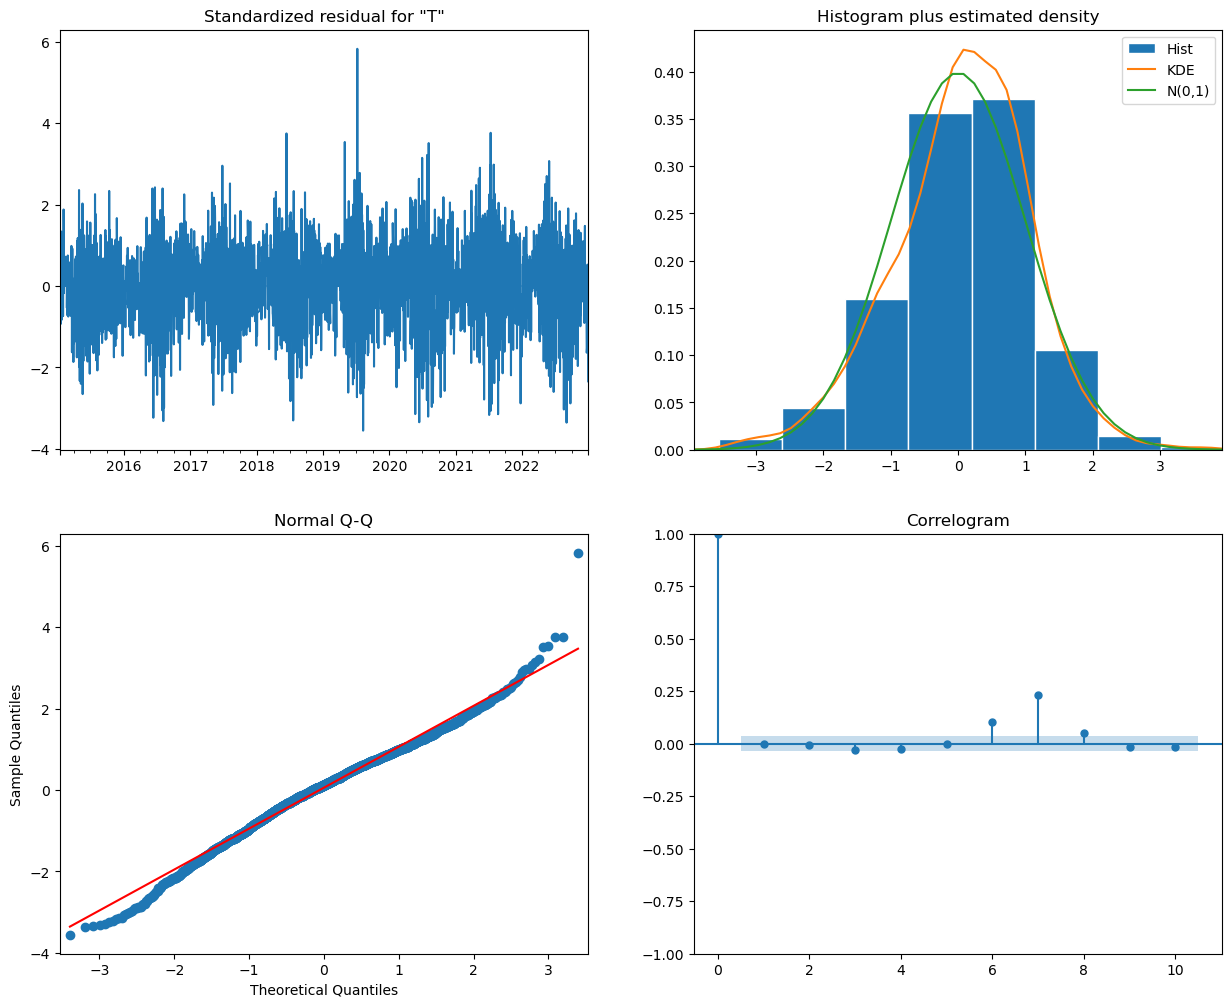

In [ ]:
exog = df_location_erhardt[['AvgTemp']]
exog = sm.add_constant(exog)

# Fit the SARIMAX model using the exogenous variable
model = SARIMAX(df_location_erhardt['Total'], exog=exog, order=(2, 0, 2), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Display the summary of the model fit
print(results.summary())
# plot the SARIMAX model diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()


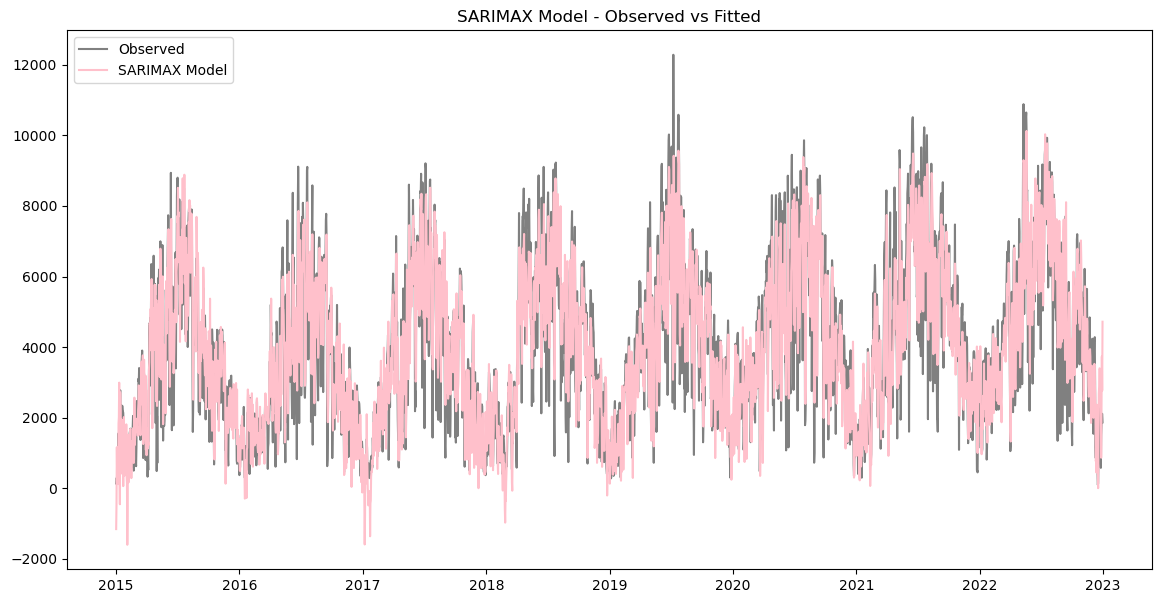

In [ ]:
# Visualize the fitted SARIMAX model
plt.figure(figsize=(14,7))
plt.plot(df_location_erhardt['Total'], color='grey',label='Observed')
plt.plot(results.fittedvalues, color='pink', label='SARIMAX Model')
plt.title('SARIMAX Model - Observed vs Fitted')
plt.legend(loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate error metrics
mae = mean_absolute_error(df_test, predicted_mean[:len(df_test)])
rmse = mean_squared_error(df_test, predicted_mean[:len(df_test)], squared=False)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 1766.5668368262347
Root Mean Squared Error (RMSE): 2190.496227770503


/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61202D+00    |proj g|=  6.55740D-02


 This problem is unconstrained.



At iterate    5    f=  8.57592D+00    |proj g|=  3.20106D-02

At iterate   10    f=  8.57216D+00    |proj g|=  3.88155D-04

At iterate   15    f=  8.57210D+00    |proj g|=  8.14618D-04

At iterate   20    f=  8.57209D+00    |proj g|=  3.94536D-04

At iterate   25    f=  8.57187D+00    |proj g|=  5.59413D-03

At iterate   30    f=  8.56843D+00    |proj g|=  2.32462D-02

At iterate   35    f=  8.48620D+00    |proj g|=  4.49008D-02

At iterate   40    f=  8.48187D+00    |proj g|=  1.38366D-04

At iterate   45    f=  8.48187D+00    |proj g|=  4.51022D-04


/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.48185D+00    |proj g|=  1.46226D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   1.462D-03   8.482D+00
  F =   8.4818538285309391     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


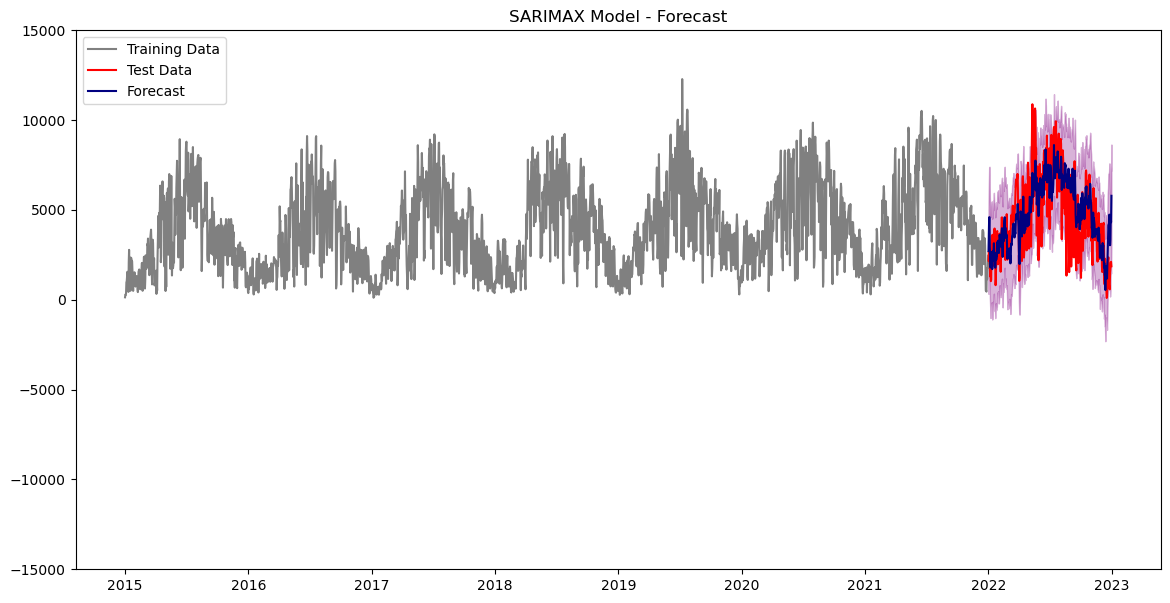

In [ ]:
# Divide the data into training and testing sets
# The training set will be used to fit the model, while the testing set will be used to evaluate the model's performance
# The training set will contain data from 2015 to 2021, and the testing set will contain data from 2022
# The testing set will be used to forecast the future values
# The training set will be used to fit the model
df_train = df_location_erhardt['Total'][:'2021-12-31']
df_test = df_location_erhardt['Total']['2022-01-01':]
exog_train = exog[:'2021-12-31']
exog_test = exog['2022-01-01':]
model = SARIMAX(df_train, exog=exog_train, order=(2, 0, 2), seasonal_order=(1, 1, 1, 12))
fitted_model = model.fit()
# Get the in-sample prediction
in_sample_prediction = fitted_model.get_prediction(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-12-31'), dynamic=False, exog=exog_train)
predicted_mean = in_sample_prediction.predicted_mean

#forecast the future values
forecast = fitted_model.get_forecast(steps=365, exog=exog_test)
predicted_mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Visualize the forecast
plt.figure(figsize=(14,7))
plt.plot(df_train, label='Training Data', color='grey')
plt.plot(df_test, label='Test Data', color='red')
plt.plot(predicted_mean_forecast, label='Forecast', color='navy')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='purple', alpha=0.3)
plt.title('SARIMAX Model - Forecast')
plt.ylim(-15000, 15000)
plt.legend(loc='upper left')
plt.show()


In [151]:
# data summary
print(df_location_erhardt.describe())

              Total      MinTemp      MaxTemp  RainfallVolume      AvgTemp  \
count   2922.000000  2922.000000  2922.000000     2922.000000  2922.000000   
mean    4045.841889     6.440075    15.508864        2.527858    10.974127   
std     2284.707047     6.718720     9.026669        5.732336     7.675076   
min      102.000000   -14.800000    -8.100000        0.000000   -10.400000   
25%     2172.250000     1.000000     8.400000        0.000000     4.825000   
50%     3750.000000     6.300000    15.500000        0.000000    10.900000   
75%     5689.750000    12.100000    22.700000        2.300000    17.200000   
max    12283.000000    21.500000    36.900000       71.200000    29.100000   

         DayOfWeek        Month         Year  
count  2922.000000  2922.000000  2922.000000  
mean      4.001027     6.522930  2018.499658  
std       1.999743     3.449293     2.291531  
min       1.000000     1.000000  2015.000000  
25%       2.000000     4.000000  2016.250000  
50%       4.000

/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62844D+00    |proj g|=  6.73619D-02


 This problem is unconstrained.



At iterate    5    f=  8.59241D+00    |proj g|=  4.61649D-02

At iterate   10    f=  8.58703D+00    |proj g|=  8.34690D-04

At iterate   15    f=  8.58700D+00    |proj g|=  1.19507D-03

At iterate   20    f=  8.58687D+00    |proj g|=  2.39402D-03

At iterate   25    f=  8.58680D+00    |proj g|=  1.79104D-03

At iterate   30    f=  8.58674D+00    |proj g|=  4.85649D-03

At iterate   35    f=  8.58576D+00    |proj g|=  5.99417D-03

At iterate   40    f=  8.56374D+00    |proj g|=  5.10373D-02

At iterate   45    f=  8.50217D+00    |proj g|=  3.67239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     80   

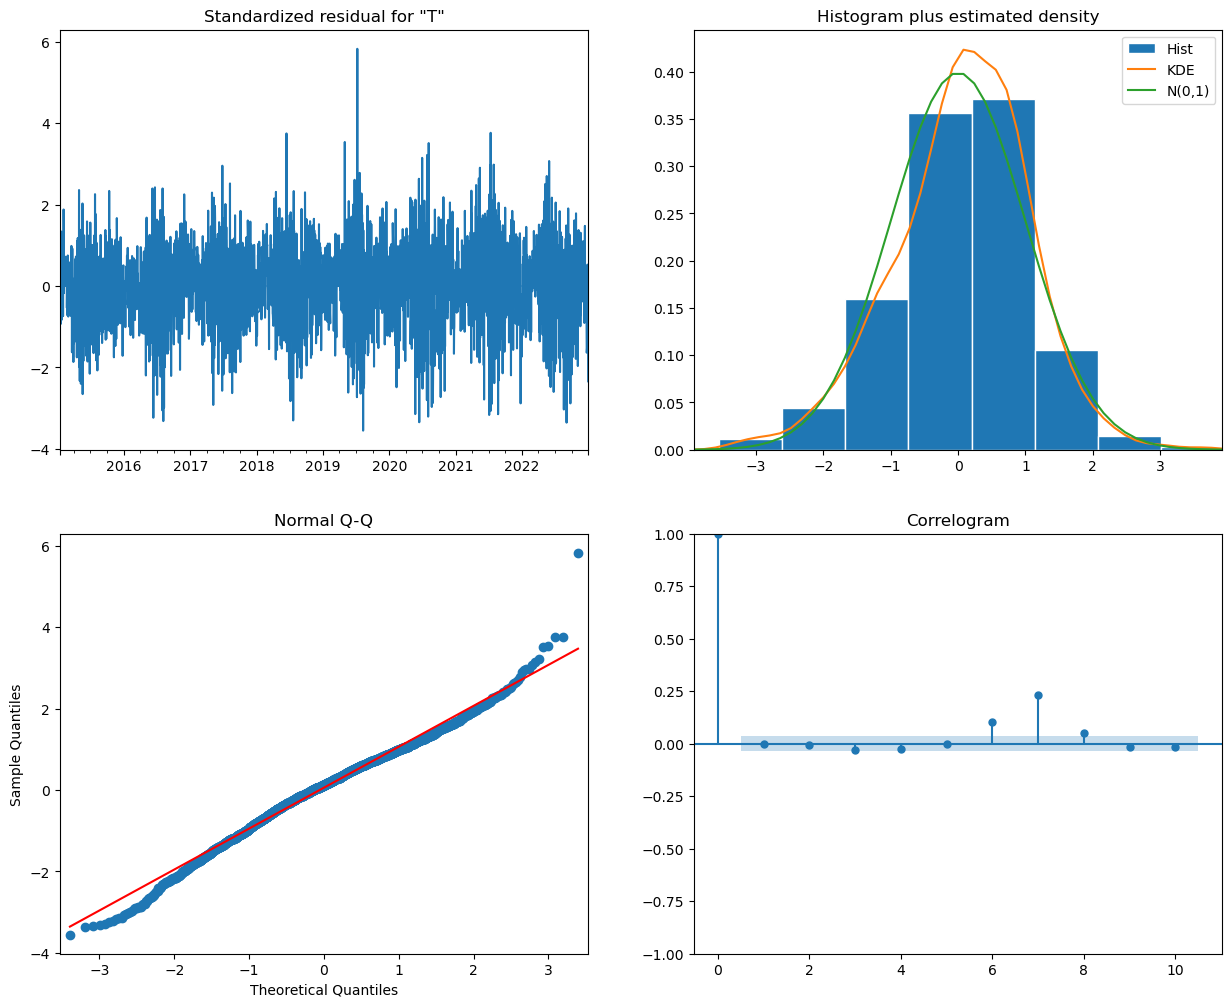

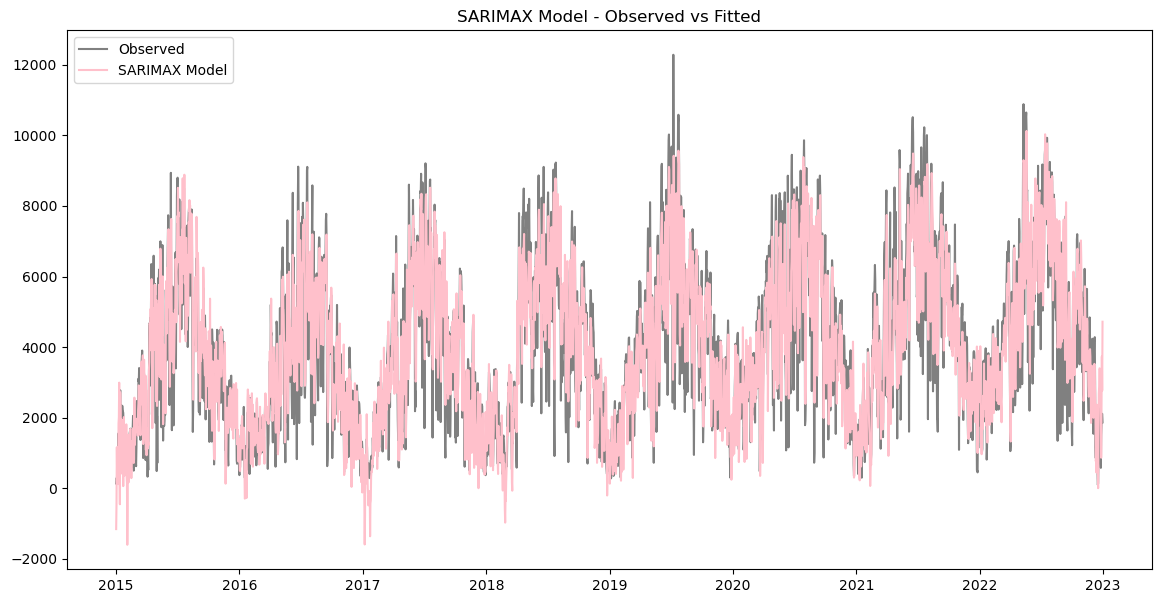

/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61209D+00    |proj g|=  6.58208D-02


 This problem is unconstrained.



At iterate    5    f=  8.57418D+00    |proj g|=  2.30069D-02

At iterate   10    f=  8.57209D+00    |proj g|=  2.88184D-04

At iterate   15    f=  8.57205D+00    |proj g|=  2.68121D-03

At iterate   20    f=  8.56942D+00    |proj g|=  2.46440D-02

At iterate   25    f=  8.55798D+00    |proj g|=  2.30538D-02

At iterate   30    f=  8.49252D+00    |proj g|=  6.36052D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  8.48265D+00    |proj g|=  1.33274D-03

At iterate   40    f=  8.48253D+00    |proj g|=  7.79655D-03

At iterate   45    f=  8.48050D+00    |proj g|=  4.87815D-03

At iterate   50    f=  8.47693D+00    |proj g|=  9.66217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     89      2     0     0   9.662D-03   8.477D+00
  F =   8.4769279079389701     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/caropaez/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


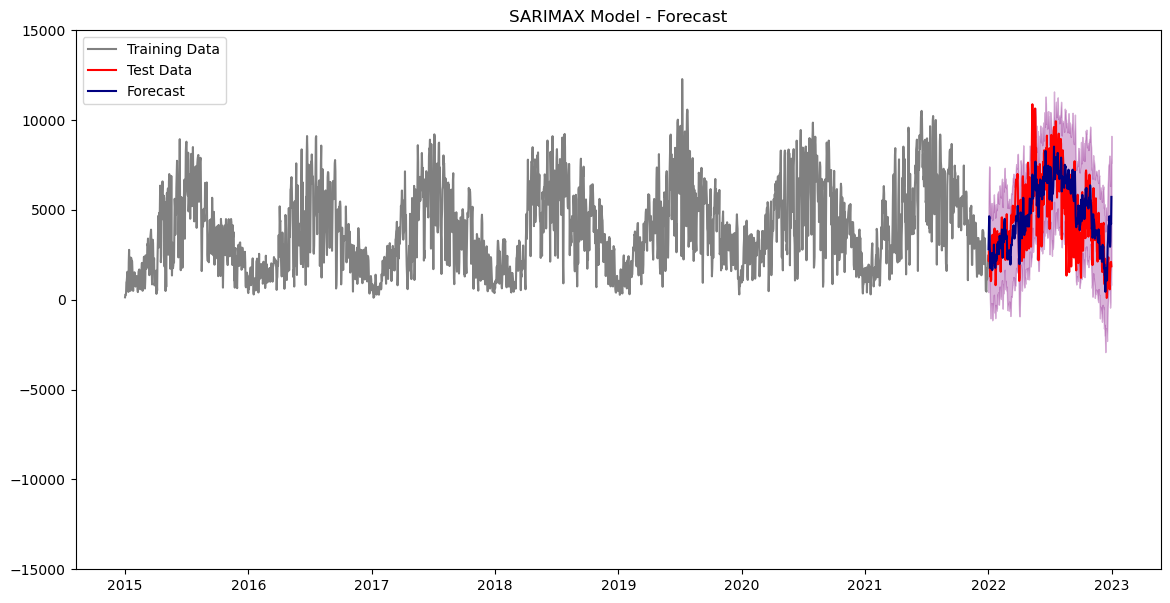

In [ ]:
# Divide the data into training and testing sets
# The training set will be used to fit the model, while the testing set will be used to evaluate the model's performance
# The training set will contain data from 2015 to 2021, and the testing set will contain data from 2022
# The testing set will be used to forecast the future values
# The training set will be used to fit the model
exog2 = df_location_erhardt[['AvgTemp', 'RainfallVolume']]
exog2 = sm.add_constant(exog2)

# Fit the SARIMAX model using the exogenous variable
model = SARIMAX(df_location_erhardt['Total'], exog=exog, order=(2, 0, 2), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Display the summary of the model fit
print(results.summary())
# plot the SARIMAX model diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Visualize the fitted SARIMAX model
plt.figure(figsize=(14,7))
plt.plot(df_location_erhardt['Total'], color='grey',label='Observed')
plt.plot(results.fittedvalues, color='pink', label='SARIMAX Model')
plt.title('SARIMAX Model - Observed vs Fitted')
plt.legend(loc='upper left')
plt.show()

exog2_train = exog2[:'2021-12-31']
exog2_test = exog2['2022-01-01':]

model = SARIMAX(df_train, exog=exog_train, order=(3, 0, 1), seasonal_order=(1, 1, 1, 12))
fitted_model = model.fit()
# Get the in-sample prediction
in_sample_prediction = fitted_model.get_prediction(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-12-31'), dynamic=False, exog=exog_train)
predicted_mean = in_sample_prediction.predicted_mean

#forecast the future values
forecast = fitted_model.get_forecast(steps=365, exog=exog_test)
predicted_mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Visualize the forecast
plt.figure(figsize=(14,7))
plt.plot(df_train, label='Training Data', color='grey')
plt.plot(df_test, label='Test Data', color='red')
plt.plot(predicted_mean_forecast, label='Forecast', color='navy')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='purple', alpha=0.3)
plt.title('SARIMAX Model - Forecast')
plt.ylim(-15000, 15000)
plt.legend(loc='upper left')
plt.show()


In [ ]:
# Calculate error metrics
mae = mean_absolute_error(df_test, predicted_mean[:len(df_test)])
rmse = mean_squared_error(df_test, predicted_mean[:len(df_test)], squared=False)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 1680.5602238427732
Root Mean Squared Error (RMSE): 2101.733912878545


## Vector Auto-Regression

Vector Autoregression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other, i.e. the relationship between the time series involved is bi-directional. It is considered as an Autoregressive model because, each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series. <br><br>
Other Autoregressive models like AR, ARMA or ARIMA are uni-directional, where, the predictors influence the Y and not vice-versa. Vector Auto Regression (VAR) models are bi-directional, i.e. the variables influence each other.

In [154]:
df_location_erhardt.describe()

,Total,MinTemp,MaxTemp,RainfallVolume,AvgTemp,DayOfWeek,Month,Year
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,4045.841889,6.440075,15.508864,2.527858,10.974127,4.001027,6.522930,2018.499658
std,2284.707047,6.718720,9.026669,5.732336,7.675076,1.999743,3.449293,2.291531
min,102.000000,-14.800000,-8.100000,0.000000,-10.400000,1.000000,1.000000,2015.000000
25%,2172.250000,1.000000,8.400000,0.000000,4.825000,2.000000,4.000000,2016.250000
50%,3750.000000,6.300000,15.500000,0.000000,10.900000,4.000000,7.000000,2018.500000
75%,5689.750000,12.100000,22.700000,2.300000,17.200000,6.000000,10.000000,2020.000000
max,12283.000000,21.500000,36.900000,71.200000,29.100000,7.000000,12.000000,2022.000000
